# Sentiment Analysis with Transformers

## Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

## Create and Split Dataset

In [2]:
class IMBDDataset(Dataset):
    def __init__(self, file_path, tokenizer):
        df = pd.read_csv(file_path)
        df["sentiment"] = np.where(df["sentiment"] == "positive", 1, 0)
        self.x = tokenizer(df["review"].tolist(), max_length=512, truncation=True, padding='max_length', return_tensors='pt')['input_ids']
        self.y = torch.tensor(df["sentiment"].values)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def create_train_test_datasets(filepath, tokenizer, split_ratio=0.7):
    dataset = IMBDDataset(filepath, tokenizer)
    train_size = int(split_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_data, test_data = random_split(dataset, [train_size, test_size])
    return train_data, test_data

## Create Dataloaders

In [3]:
def create_dataloader(training_data, test_data, batch_size):
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

## Select Device

In [4]:
def select_device():
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    print(f"Using device: {device}")
    return device

## Define the model

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, vocab_size, embed_size=512, encoders=2, num_classes=2):
        super(NeuralNetwork, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.encoder_layer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_size, nhead=4, batch_first=True, dropout=0.3),
            num_layers=encoders)
        self.final_layers = nn.Sequential(
            nn.ReLU(),
            nn.Linear(embed_size*embed_size, num_classes)
        )

    def forward(self, x):
        emb = self.embed(x)
        out_encod = self.encoder_layer(emb)
        out_encod = out_encod.reshape(out_encod.shape[0], out_encod.shape[1]*out_encod.shape[2])
        logits = self.final_layers(out_encod)
        return logits

def load_model(weights, device, tokenizer):
    model = NeuralNetwork(tokenizer.vocab_size).to(device)
    if os.path.exists(weights):
        try:
            model.load_state_dict(torch.load(weights), strict=False)
        except Exception as e:
            print(f"No weights were loaded: {e}")
    return model

## Train & Test

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 25 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device, best_accuracy, best_weights):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    accuracy = correct / size

    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    ConfusionMatrixDisplay.from_predictions(all_labels, all_preds)
    plt.show()

    # Save the model if it has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = model.state_dict()

    return best_accuracy, best_weights

## Main Function

In [7]:
def main(file_path, learning_rate, batch_size, epochs, tokenizer):
    device = select_device()
    loss_fn = nn.CrossEntropyLoss()
    model = load_model('model_weights.pth', device, tokenizer)
    best_accuracy = 0.0
    best_weights = None

    train_on = input("Do you want to train? Yes(y), No(enter): ")
    if train_on.lower() == 'y':
        training_data, test_data = create_train_test_datasets(file_path, tokenizer)
        train_dataloader, test_dataloader = create_dataloader(training_data, test_data, batch_size)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        next_train = True
        while next_train:
            for t in range(epochs):
                print(f"Epoch {t+1}\n-------------------------------")
                train_loop(train_dataloader, model, loss_fn, optimizer, device)
                best_accuracy, best_weights = test_loop(test_dataloader, model, loss_fn, device, best_accuracy, best_weights)

            print(f"Best accuracy: {(100 * best_accuracy):.1f}% with learning rate {learning_rate}")
            save_on = input("Do you want to save? Yes(Any), No(enter): ")
            if save_on:
              print("Done! Saving process...")
              torch.save(best_weights, 'model_weights.pth')

            stop_train = input("Should we continue training? No(Any) Yes(Enter) -> ")
            if stop_train:
                next_train = False
            else:
                change_lr = input("Change the learning rate? Yes(Any) No(Enter) -> ")
                if change_lr:
                    try:
                        learning_rate = float(input("New learning rate: "))
                    except:
                        print("Ignoring new learning rate")
                change_epochs = input(f"Change the number of epochs ({epochs})? Yes(Any) No(Enter) -> ")
                if change_epochs:
                    try:
                        epochs = int(input("New number of epochs: "))
                    except:
                        print("Ignoring new number of epochs")
    else:
        training_data, test_data = create_train_test_datasets(file_path, tokenizer)
        _, test_dataloader = create_dataloader(training_data, test_data, batch_size)
        test_loop(test_dataloader, model, loss_fn, device)

## Call Main

Using device: cuda
Epoch 1
-------------------------------
loss: 0.703104  [   64/35000]
loss: 0.733172  [ 1664/35000]
loss: 0.865978  [ 3264/35000]
loss: 0.666375  [ 4864/35000]
loss: 0.744632  [ 6464/35000]
loss: 0.727591  [ 8064/35000]
loss: 0.652699  [ 9664/35000]
loss: 0.687911  [11264/35000]
loss: 0.680402  [12864/35000]
loss: 0.795201  [14464/35000]
loss: 0.678811  [16064/35000]
loss: 0.705876  [17664/35000]
loss: 0.795829  [19264/35000]
loss: 0.695285  [20864/35000]
loss: 0.768113  [22464/35000]
loss: 0.710978  [24064/35000]
loss: 0.720731  [25664/35000]
loss: 0.689742  [27264/35000]
loss: 0.686797  [28864/35000]
loss: 0.575245  [30464/35000]
loss: 0.600358  [32064/35000]
loss: 0.555999  [33664/35000]
Test Error: 
 Accuracy: 65.0%, Avg loss: 0.619382 



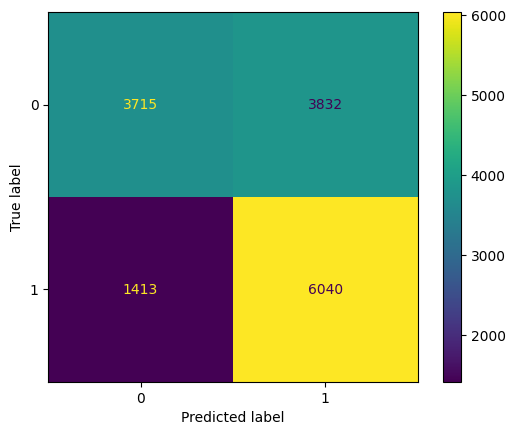

Epoch 2
-------------------------------
loss: 0.570683  [   64/35000]
loss: 0.663700  [ 1664/35000]
loss: 0.487769  [ 3264/35000]
loss: 0.594994  [ 4864/35000]
loss: 0.622365  [ 6464/35000]
loss: 0.512632  [ 8064/35000]
loss: 0.486812  [ 9664/35000]
loss: 0.597643  [11264/35000]
loss: 0.657632  [12864/35000]
loss: 0.573643  [14464/35000]
loss: 0.551342  [16064/35000]
loss: 0.494990  [17664/35000]
loss: 0.525843  [19264/35000]
loss: 0.590378  [20864/35000]
loss: 0.637191  [22464/35000]
loss: 0.590192  [24064/35000]
loss: 0.451732  [25664/35000]
loss: 0.587036  [27264/35000]
loss: 0.556980  [28864/35000]
loss: 0.485497  [30464/35000]
loss: 0.507667  [32064/35000]
loss: 0.518025  [33664/35000]
Test Error: 
 Accuracy: 71.4%, Avg loss: 0.547597 



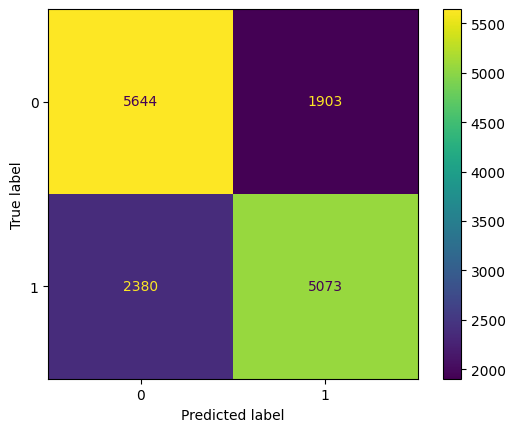

Epoch 3
-------------------------------
loss: 0.459323  [   64/35000]
loss: 0.490462  [ 1664/35000]
loss: 0.509923  [ 3264/35000]
loss: 0.393402  [ 4864/35000]
loss: 0.433436  [ 6464/35000]
loss: 0.402531  [ 8064/35000]
loss: 0.512870  [ 9664/35000]
loss: 0.459744  [11264/35000]
loss: 0.477665  [12864/35000]
loss: 0.407919  [14464/35000]
loss: 0.445442  [16064/35000]
loss: 0.363494  [17664/35000]
loss: 0.400910  [19264/35000]
loss: 0.554049  [20864/35000]
loss: 0.473402  [22464/35000]
loss: 0.419615  [24064/35000]
loss: 0.416395  [25664/35000]
loss: 0.342371  [27264/35000]
loss: 0.425248  [28864/35000]
loss: 0.351245  [30464/35000]
loss: 0.418865  [32064/35000]
loss: 0.380905  [33664/35000]
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.494282 



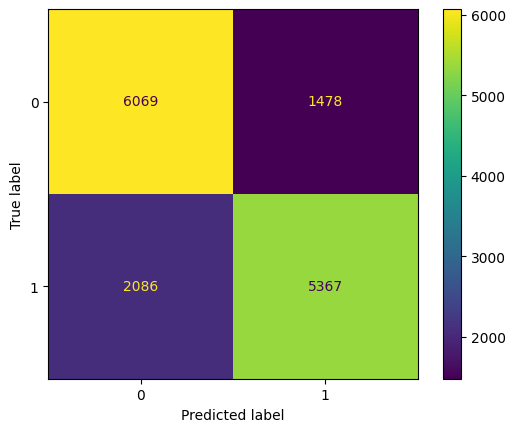

Epoch 4
-------------------------------
loss: 0.413190  [   64/35000]
loss: 0.472006  [ 1664/35000]
loss: 0.371728  [ 3264/35000]
loss: 0.402338  [ 4864/35000]
loss: 0.455122  [ 6464/35000]
loss: 0.466973  [ 8064/35000]
loss: 0.411997  [ 9664/35000]
loss: 0.376218  [11264/35000]
loss: 0.349397  [12864/35000]
loss: 0.420067  [14464/35000]
loss: 0.367689  [16064/35000]
loss: 0.394292  [17664/35000]
loss: 0.335834  [19264/35000]
loss: 0.332239  [20864/35000]
loss: 0.270471  [22464/35000]
loss: 0.291723  [24064/35000]
loss: 0.429560  [25664/35000]
loss: 0.350407  [27264/35000]
loss: 0.336702  [28864/35000]
loss: 0.284316  [30464/35000]
loss: 0.322082  [32064/35000]
loss: 0.282413  [33664/35000]
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.503429 



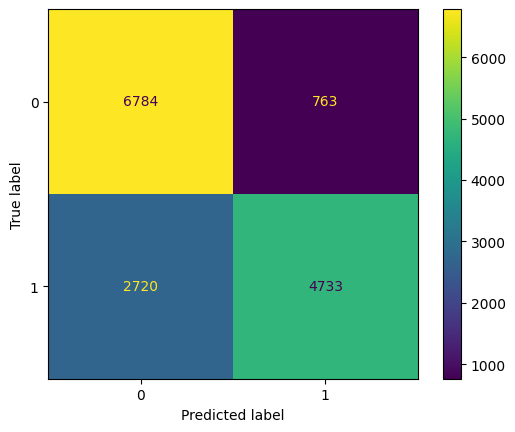

Epoch 5
-------------------------------
loss: 0.413236  [   64/35000]
loss: 0.209316  [ 1664/35000]
loss: 0.311017  [ 3264/35000]
loss: 0.248368  [ 4864/35000]
loss: 0.424713  [ 6464/35000]
loss: 0.239098  [ 8064/35000]
loss: 0.299280  [ 9664/35000]
loss: 0.337818  [11264/35000]
loss: 0.343626  [12864/35000]
loss: 0.301285  [14464/35000]
loss: 0.260232  [16064/35000]
loss: 0.395681  [17664/35000]
loss: 0.402433  [19264/35000]
loss: 0.290513  [20864/35000]
loss: 0.266890  [22464/35000]
loss: 0.372857  [24064/35000]
loss: 0.274546  [25664/35000]
loss: 0.450955  [27264/35000]
loss: 0.239270  [28864/35000]
loss: 0.311405  [30464/35000]
loss: 0.338988  [32064/35000]
loss: 0.341679  [33664/35000]
Test Error: 
 Accuracy: 80.2%, Avg loss: 0.423639 



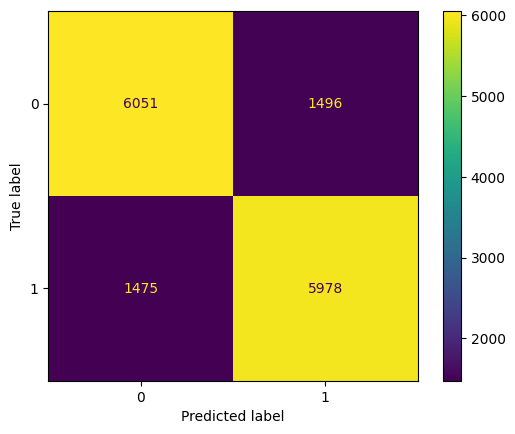

Best accuracy: 80.2% with learning rate 1e-05
Epoch 1
-------------------------------
loss: 0.232181  [   64/35000]
loss: 0.279417  [ 1664/35000]
loss: 0.242716  [ 3264/35000]
loss: 0.251997  [ 4864/35000]
loss: 0.500361  [ 6464/35000]
loss: 0.412007  [ 8064/35000]
loss: 0.227892  [ 9664/35000]
loss: 0.257928  [11264/35000]
loss: 0.352435  [12864/35000]
loss: 0.178829  [14464/35000]
loss: 0.161726  [16064/35000]
loss: 0.238835  [17664/35000]
loss: 0.176019  [19264/35000]
loss: 0.436507  [20864/35000]
loss: 0.186824  [22464/35000]
loss: 0.260674  [24064/35000]
loss: 0.331527  [25664/35000]
loss: 0.284129  [27264/35000]
loss: 0.276658  [28864/35000]
loss: 0.266980  [30464/35000]
loss: 0.213813  [32064/35000]
loss: 0.303358  [33664/35000]
Test Error: 
 Accuracy: 81.2%, Avg loss: 0.411276 



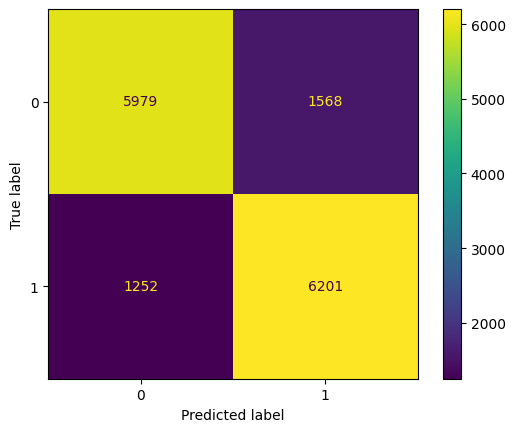

Epoch 2
-------------------------------
loss: 0.234238  [   64/35000]
loss: 0.248457  [ 1664/35000]
loss: 0.313298  [ 3264/35000]
loss: 0.265146  [ 4864/35000]
loss: 0.261433  [ 6464/35000]
loss: 0.153614  [ 8064/35000]
loss: 0.228377  [ 9664/35000]
loss: 0.331660  [11264/35000]
loss: 0.302610  [12864/35000]
loss: 0.276922  [14464/35000]
loss: 0.238605  [16064/35000]
loss: 0.236125  [17664/35000]
loss: 0.239347  [19264/35000]
loss: 0.314388  [20864/35000]
loss: 0.217054  [22464/35000]
loss: 0.240657  [24064/35000]
loss: 0.193868  [25664/35000]
loss: 0.204485  [27264/35000]
loss: 0.198732  [28864/35000]
loss: 0.215020  [30464/35000]
loss: 0.300479  [32064/35000]
loss: 0.257544  [33664/35000]
Test Error: 
 Accuracy: 81.4%, Avg loss: 0.416313 



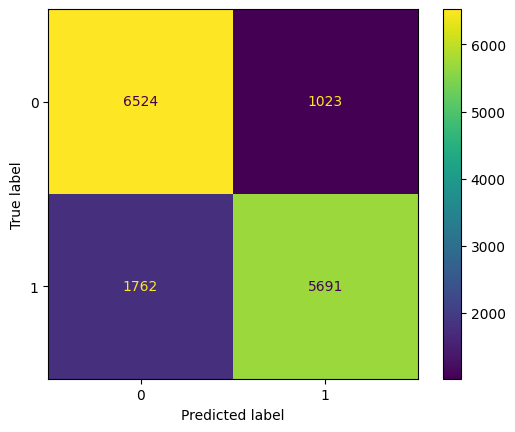

Epoch 3
-------------------------------
loss: 0.215421  [   64/35000]
loss: 0.261105  [ 1664/35000]
loss: 0.159512  [ 3264/35000]
loss: 0.228944  [ 4864/35000]
loss: 0.243227  [ 6464/35000]
loss: 0.199566  [ 8064/35000]
loss: 0.232780  [ 9664/35000]
loss: 0.167638  [11264/35000]
loss: 0.233909  [12864/35000]
loss: 0.146785  [14464/35000]
loss: 0.265812  [16064/35000]
loss: 0.188302  [17664/35000]
loss: 0.267400  [19264/35000]
loss: 0.130515  [20864/35000]
loss: 0.199589  [22464/35000]
loss: 0.171575  [24064/35000]
loss: 0.264958  [25664/35000]
loss: 0.179827  [27264/35000]
loss: 0.285384  [28864/35000]
loss: 0.170528  [30464/35000]
loss: 0.250905  [32064/35000]
loss: 0.181755  [33664/35000]
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.437587 



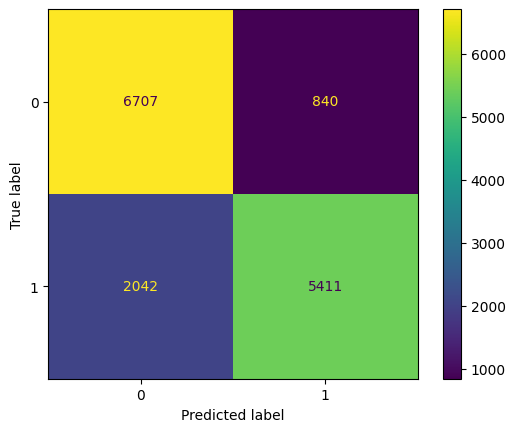

Epoch 4
-------------------------------
loss: 0.231715  [   64/35000]
loss: 0.167183  [ 1664/35000]
loss: 0.229764  [ 3264/35000]
loss: 0.185975  [ 4864/35000]
loss: 0.238064  [ 6464/35000]
loss: 0.143936  [ 8064/35000]
loss: 0.247293  [ 9664/35000]
loss: 0.199540  [11264/35000]
loss: 0.219583  [12864/35000]
loss: 0.183020  [14464/35000]
loss: 0.178106  [16064/35000]
loss: 0.165756  [17664/35000]
loss: 0.194214  [19264/35000]
loss: 0.166623  [20864/35000]
loss: 0.138204  [22464/35000]
loss: 0.147769  [24064/35000]
loss: 0.152137  [25664/35000]
loss: 0.164373  [27264/35000]
loss: 0.163152  [28864/35000]
loss: 0.142148  [30464/35000]
loss: 0.220982  [32064/35000]
loss: 0.137069  [33664/35000]
Test Error: 
 Accuracy: 81.8%, Avg loss: 0.406369 



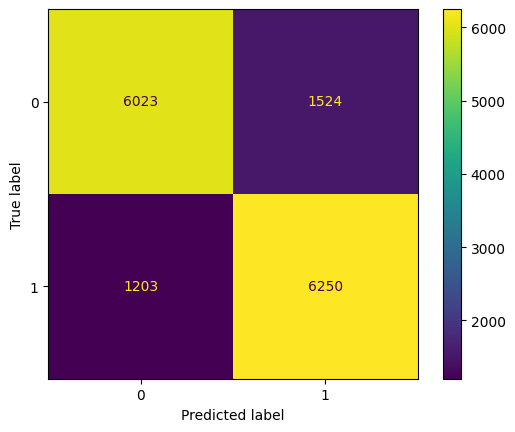

Epoch 5
-------------------------------
loss: 0.170813  [   64/35000]
loss: 0.166945  [ 1664/35000]
loss: 0.116794  [ 3264/35000]
loss: 0.201123  [ 4864/35000]
loss: 0.158139  [ 6464/35000]
loss: 0.119610  [ 8064/35000]
loss: 0.153182  [ 9664/35000]
loss: 0.091606  [11264/35000]
loss: 0.107669  [12864/35000]
loss: 0.097073  [14464/35000]
loss: 0.260648  [16064/35000]
loss: 0.188406  [17664/35000]
loss: 0.146054  [19264/35000]
loss: 0.256174  [20864/35000]
loss: 0.197408  [22464/35000]
loss: 0.169865  [24064/35000]
loss: 0.220126  [25664/35000]
loss: 0.209351  [27264/35000]
loss: 0.174383  [28864/35000]
loss: 0.174897  [30464/35000]
loss: 0.242695  [32064/35000]
loss: 0.138568  [33664/35000]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.396760 



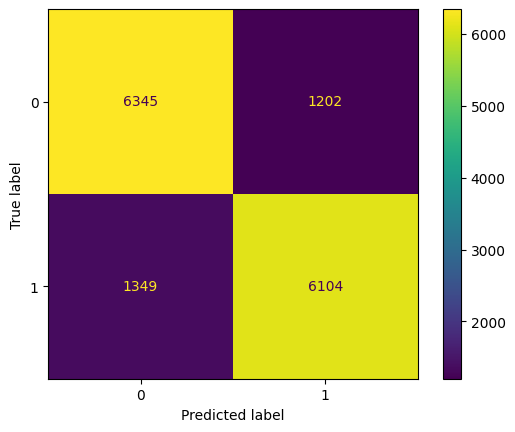

Best accuracy: 83.0% with learning rate 1e-05


In [ ]:
if __name__ == '__main__':
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    file_path = 'IMDB_Dataset.csv'
    learning_rate = 0.0001
    batch_size = 96
    epochs = 10
    main(file_path, learning_rate, batch_size, epochs, tokenizer)